In [1]:
import os
from sys import getsizeof
from time import sleep
import json
import pickle
import re
import inspect
from warnings import filterwarnings
from typing import Optional

import numpy as np
import nltk
import matplotlib.pyplot as plt
import torch
from transformers import (
	BartTokenizer, BartForConditionalGeneration,
	T5Tokenizer, T5ForConditionalGeneration,
	PegasusForConditionalGeneration, PegasusTokenizerFast,
	GPT2TokenizerFast
)
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from dotenv import load_dotenv

from utils.helpers import *
from utils.encoders import *
from utils.pipelines import *
from utils.trainer_utils import *
from utils.evaluator_utils import *

In [2]:
def plot_histogram(data):
	bins = int(len(data) ** .5)
	plt.hist(data, bins=bins)
	plt.show()

inf = float("inf")
filterwarnings("ignore")
device = get_device()
# device = "cpu"
load_dotenv()

True

In [3]:
data_dir = "/Users/naman/Workspace/Data/Long-Document-Summarization"
data_dir = "/home/nchibbar/Data"

bart_dir = f"{data_dir}/Models/BART"
t5_dir = f"{data_dir}/Models/T5"
pegasus_dir = f"{data_dir}/Models/PEGASUS"
gpt_dir = f"{data_dir}/Models/GPT-3.5-turbo-tokenizer"

govreport_dir = f"{data_dir}/GovReport/processed"
bigpatent_dir = f"{data_dir}/BigPatent/processed"
govreport_files = os.listdir(govreport_dir)
bigpatent_files = os.listdir(bigpatent_dir)

len(govreport_files), len(bigpatent_files)

7238

In [4]:
# Sentence transformer
# Automatically loads into gpu if available
sent_dir = f"{data_dir}/Models/Sent-Transformer"
sent_encoder = SentenceTransformer(sent_dir)

name = "bart"

match name:

	case "bart":
		tokenizer = BartTokenizer.from_pretrained(bart_dir)
		model = BartForConditionalGeneration.from_pretrained(bart_dir)
		context_size = model.config.max_position_embeddings

	case "t5":
		tokenizer = T5Tokenizer.from_pretrained(t5_dir)
		model = T5ForConditionalGeneration.from_pretrained(t5_dir)
		context_size = model.config.n_positions

	case "pegasus":
		tokenizer = PegasusTokenizerFast.from_pretrained(pegasus_dir)
		model = PegasusForConditionalGeneration.from_pretrained(pegasus_dir)
		context_size = model.config.max_position_embeddings

# GPT 3.5 turbo tokenizer
gpt_tokenizer = GPT2TokenizerFast.from_pretrained(gpt_dir)
gpt_model = "gpt-3.5-turbo"
gpt_context_size = 4096

context_size

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1024

In [5]:
preprocessor = TextProcessor(preprocessing=True)
postprocessor = None

## BigPatent

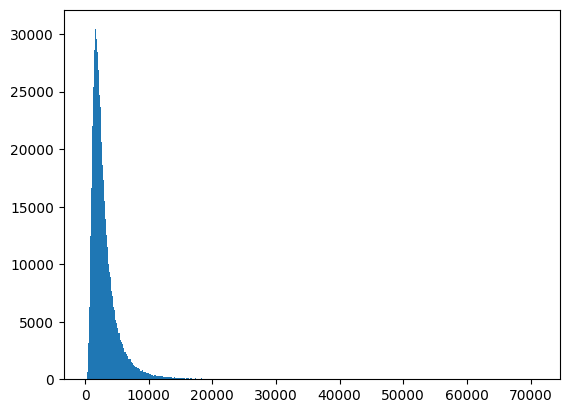

In [8]:
word_counts = []
for file in bigpatent_files:
	file_path = f"{bigpatent_dir}/{file}"
	with open(file_path) as fp:
		data = json.load(fp)
	for text in data["texts"]:
		word_counts.append(count_words(text))

bins = int(len(word_counts) ** .5)
plt.hist(word_counts, bins=bins)
plt.show()

In [9]:
max(word_counts), min(word_counts), np.mean(word_counts)

(71027, 164, 3055.7211252443412)

In [10]:
sum([
	1
	for count in word_counts
	if count > 40_000
])

152

## Rough

In [13]:
min_words = 10_000
max_words = inf
max_texts = inf
texts, summaries = [], []
num_texts = 0
for file in govreport_files:
	file_path = f"{govreport_dir}/{file}"
	with open(file_path) as fp:
		data = json.load(fp)
	if min_words < count_words(data["text"]) < max_words:
		texts.append(data["text"])
		summaries.append(data["summary"])
		num_texts += 1
	if num_texts == max_texts:
		break

num_texts

1574

In [14]:
segment_min_words = 20
text_segmenter = TextSegmenter(nltk.sent_tokenize, segment_min_words)

In [15]:
keywords_preprocessor = TextProcessor(
	only_words_nums = True,
	remove_nums = True
)
stop_words = get_stop_words(extra_stop_words=STOP_WORDS)
len(stop_words)

392

In [16]:
min_tokens_frac = .5
min_summary_tokens = 400
head_size = .5
threshold = .7
boost = .03
num_keywords = 20
seed = 69
system_prompt = "You will be given some segments of a very long document. Your task is to summarize the entire document as a whole by extracting key information and ideas from the segments. Generate a detailed, concise, and coherent summary in 500 words. Do not refer to the document in the summary in any way."

encoders = [
	TruncateMiddle(
		tokenizer, context_size, head_size, preprocessor, True
	),
	UniformSampler(
		tokenizer, min_tokens_frac * context_size, context_size,
		text_segmenter, preprocessor, True, seed
	),
	SegmentSampler(
		tokenizer, min_tokens_frac * context_size, context_size,
		text_segmenter, sent_encoder, preprocessor, threshold, boost, seed
	),
	RemoveRedundancy(
		tokenizer, min_tokens_frac * context_size, context_size,
		text_segmenter, sent_encoder, preprocessor, threshold, seed
	),
	KeywordScorer(
		tokenizer, context_size, text_segmenter, sent_encoder,
		preprocessor, num_keywords, keywords_preprocessor, stop_words
	)
]

pipelines = [
	SummarizationPipeline(
		model, enc, postprocessor, min_summary_tokens,
		context_size, device
	) for enc in encoders
]

gpt_encoders = [
	TruncateMiddle(
		gpt_tokenizer, gpt_context_size, head_size, preprocessor
	),
	UniformSampler(
		gpt_tokenizer, min_tokens_frac * gpt_context_size, gpt_context_size,
		text_segmenter, preprocessor, seed
	),
	SegmentSampler(
		gpt_tokenizer, min_tokens_frac * gpt_context_size, gpt_context_size,
		text_segmenter, sent_encoder, preprocessor, threshold, boost, seed
	),
	RemoveRedundancy(
		gpt_tokenizer, min_tokens_frac * gpt_context_size, gpt_context_size,
		text_segmenter, sent_encoder, preprocessor, threshold, seed
	)
]

gpt_pipelines = [
	OpenAIPipeline(
		gpt_model, enc, system_prompt=system_prompt
	) for enc in gpt_encoders
]

In [ ]:
processed_texts = preprocessor(texts)

In [11]:
max_word_segments = []
avg_segment = 0
total_segments = 0
for text in processed_texts:
	segments = text_segmenter(text)
	for segment in segments:
		avg_segment += count_words(segment)
		total_segments += 1
	max_word_segments.append(
		max(segments, key=lambda segment: count_words(segment))
	)
avg_segment /= total_segments
avg_segment

35.365354226594576

In [12]:
bearable_words = 150
for i, segment in enumerate(max_word_segments):
	words = count_words(segment)
	if words > bearable_words:
		print(
			f"{i} {words}: {repr(segment)}",
			end = "\n\n"
		)

23 152: 'Patent proprietorswho wish to compel others to observe their intellectual property rights must usually commencelitigation in the federal district courts (35) The U.S Court of Appeals for the Federal Circuit possessesexclusive national jurisdiction over all patent appeals from the district courts, (36) while the U.S SupremeCourt possesses discretionary authority to review cases decided by the Federal Circuit (37)\n\nSubsection The Common Law Experimental Use Privilege:\n\nSubsection General Principles:\n\nUnder the Patent Act of 1952, any individual who makes, uses, sells, offers to sell, or importsinto the United States a patented invention without the authorization of the patent owner facesliability for infringement (38) Although the Patent Act authorizes a number of defenses to acharge of patent infringement -- such as that the patented invention does not meet the statutorystandards for patentability and was improvidently awarded a patent by the USPTO (39) -- the statute doe

In [15]:
ind = 7143
print(
	processed_texts[ind], texts[ind],
	sep = f"\n\n{"=" * 400}\n\n"
)

Title: Detention of American Citizens as Enemy Combatants Subsection Background:

The Attorney General announced on June 10, 2002, that an American citizen, Jose Padilla, also known as Abdullah Muhajir, was arrested May 8, 2002 upon his return from Pakistan, allegedlywith the intent of participating in a plot to use a radiological bomb against unknown targets withinthe United States. Padilla was detained under a court order as a material witness until theDepartment of Justice faced a court deadline to either bring charges or release him. Afterprosecutors reportedly either lacked the physical evidence or were unwilling to disclose classifiedevidence necessary to bring charges against Padilla, President Bush signed an unspecified orderdeclaring him to be an "enemy combatant," and transferred him to the custody of the Department ofDefense (9) TheAdministration takes the position that the law of war allows the United States to detain indefinitelymembers, agents or associates of Al Qaeda an

In [36]:
inps = encoders[-1](texts[1])
inps

{'input_ids': tensor([[    0,   133, 32442,  ...,  2069,     4,     2]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}

In [46]:
out = model.generate(**inps, min_length=400, max_length=600, early_stopping=True)
out.shape

torch.Size([1, 403])

In [43]:
tokenizer.decode(out[0], skip_special_tokens=True)

'The omnibus law contained regular appropriations for FY2009 of $27.59 billion for Interior, Environment, and Related Agencies. This funding was $1.78 billion (7%) over the FY2009 Bush Administration request of $25.81 billion, but $825.9 million (3%) below the FY2008 level of $28.42 billion. While the President sought to increase funds for some agencies, he requested reduced funds for most agencies. Most of this funding was provided for two large programs within the omnibus appropriations law. In addition to two programs that were funded, President Bush had sought funds for the Department of the Forest Service. The omnibus included $7052 million for other operations, an increase of $73.7 million (5%) from the regular appropriations requests for FY2008 and $23.4 million (9%) more than the President\'s request. See Table 21 for more details on the funding levels for the Interior, Environmental, and Forest Service agencies in FY2009 and for other programs within this funding bill. For FY2

In [31]:
tokenizer.decode(inps["input_ids"][0])

'Taken together, the two laws provided a total of $38.54 billion for FY2009. Subsection Introduction: The annual Interior, Environment, and Related Agencies appropriations bill includes funding for agencies and programs in three separate federal departments, as well as numerous related agencies and bureaus. This report contains final FY2009 appropriations levels for agencies, programs, and activities as enacted in the Omnibus Appropriations Act, 2009 (P.L 111-8, H.R 1105). These funds generally are referred to as omnibus funds, or funds provided by the omnibus law. Increases and decreases generally are calculated on comparisons between these FY2009 omnibus funding levels and those requested by President Bush for FY2009 and enacted for FY2008. This law contained additional FY2009 funding for some of the agencies and programs typically funded by the Interior, Environment, and Related Agencies Appropriations bill. The FY2009 omnibus funding represented a $265.5 million increase (1%) over 

In [25]:
tokenizer.pad({"input_ids": [[1, 2, 3], [1, 2]]}, verbose=False)

{'input_ids': [[1, 2, 3], [1, 2, 1]], 'attention_mask': [[1, 1, 1], [1, 1, 0]]}